# Patient Biopsies

## Goals

1. Which subpopulation of each biopsy is most plastic? 
    - Expectation: We will be able to quantify plasticity of the cancer cells and then compare within each sample to determine which cluster is most plastic.
    - Methods: 
        - **Should we batch correct?**
        - RNA velocity and dimensionality reduction (**what DR do we want to use?**)
        - Plasticity quantification using two metrics (**what do the end states look like? Are there clusters/ what is the multiplicity of eigenvalue 1?**)
    - Possible pitfalls: Not much range in plasticity within a data set. Several regions of the data set have high plasticity. We need to decide what dimensionality reduction to use- PCA space? We proposed working on the UMAP, which will not work well if there are several subpopulations that are discontinuous.
2. Is it consistent across treatments? 
    - We expect that the post-treatment tumors will have subpopulations with higher plasticity. We will want to compare what subpopulations there are and the plasticity of each. 
    - Methods:
        - Identify cancer subtypes to match across samples/treatment.
        - Compare plasticity of each subtype directly.
        - Consider size of each sample and each subpopulation-- **does number of cells confound plasticity calculations?**
    - Pitfalls: we will need to match subpopulations across samples-- for example, if there are A cells before and after treatment, do those change significantly in phenotype or plasticity?
3. How does the presence and proportion of immune cells affect plasticity of cancer cells?

In [1]:
import sys
sys.path.insert(1, "/Users/smgroves/Dropbox (VU Basic Sciences)/pycharm_workspace/mazebox/")
import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read in data and preprocess.
1. Use cell_ids_biopsies.csv to subset data and identify cancer cells versus immune cells.
2. Filter genes, normalize, and log-transform.
3. Visualize using UMAP and/or tSNE.
4. Cluster data using leiden or louvain.
4. Find marker genes for each cluster, as well as expression of SCLC markers.

In [2]:
indir = "../data/patient-biopsies/"
outdir = './out/processed-data/patient-biopsies'

In [5]:
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
samples = [f for f in os.listdir(indir) if f.endswith('.loom')]
print(samples)
[a1,a2,a3,a4,a5,a6,a7,a8,a9] = [mb.pp.read_loom(sample.split('.')[0], indir) for sample in samples] #split to remove .loom from file name


['SC134_142A_FYKY4.loom', 'SC123_138A_57U8G.loom', 'SC134_145A_43LG5.loom', 'SC123_135A_5K9UN.loom', 'SC140_145B_GLO1Q.loom', 'SC123_140A_6SIM9.loom', 'SC140_142B_DB04B.loom', 'SC134_135B_HLS1M.loom', 'SC134_146A_D4F1K.loom']


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' 

## Filter and concatenate

In [6]:
tfs = ['SP100', 'FOSL1', 'HES1', 'NFKBIZ', 'RELB', 'EPAS1', 'BCL3', 'REST', 'SP110', 'NFKB2', 'TEAD2', 'HMG20B', 'SIX5',
       'RARG', 'TEAD4', 'ZNF217', 'SP140L', 'SOX18', 'HOXC13', 'STAT6', 'ETV4', 'KLF2', 'MITF', 'NR0B2', 'ASCL1', 'ZBTB7C', 'ELF3',
       'RORC', 'FOXA2', 'ETS2','TOX3', 'XBP1', 'ST18', 'FOXA1', 'OVOL2', 'ZNF664', 'TBX10', 'PROX1', 'ETV6', 'CEBPD', 'TFCP2L1', 'FOXJ3',
       'ZNF407', 'ZNF511','ZNF396', 'RBPJ', 'ZSCAN31', 'HOXB5', 'ZNF3', 'TSHZ2', 'ZBTB16', 'ZNF10', 'FLI1', 'GATA4', 'NR0B1', 'NHLH1',
       'NEUROD6', 'ZNF581', 'TCF15', 'LYAR', 'ISL2', 'OLIG2', 'NEUROD1', 'INSM1', 'PAX5', 'SP6', 'MYT1', 'HES6', 'ZNF24', 'ISL1', 'ZNF397',
       'SOX11', 'ZNF253', 'SMAD4', 'RBP1', 'ONECUT2', 'ZNF711', 'DLX5', 'GRIP1', 'ZNF157', 'ZNF713', 'ZNF136', 'FOXN4', 'PATZ1', 'ZNF491',
       'ZBTB21', 'KLF12', 'ZNF501', 'ZNF785', 'CXXC1', 'ZNF324', 'ZNF764', 'ZBTB18', 'KAT8', 'ZNF334', 'POU4F1', 'ZNF250', 'ZNF132',
       'SALL2', 'DLX6', 'MBD1','SOX1', 'ZFP3', 'ZNF543', 'POU2F1', 'NONO', 'SMAD9', 'ZKSCAN2', 'TCF12', 'VEZF1', 'TOX', 'BHLHE22', 'MTA1',
       'TCF3', 'SCRT2', 'RFX7','NHLH2', 'SCRT1', 'RCOR2', 'PURG', 'TBPL1', 'TCF4', 'EBF1', 'ZNF749', 'NEUROD2', 'ZNF423', 'BACH2', 'GLI1',
       'ZFP64','NKX2-1', 'MYC', 'YAP1', 'POU2F3', 'MYCL', 'MYCN', 'ASCL2', 'AVIL', 'CHAT', 'GFI1B',
      'CHGA','EPCAM']


Dropkick is a tool to get rid of empty and low-quality droplets based on ambient reads. It should be applied to each sample separately, so we will apply first and then concantenate the data into one AnnData object.

In [7]:
#['SC134_142A_FYKY4.loom', 'SC123_138A_57U8G.loom', 'SC134_145A_43LG5.loom', 'SC123_135A_5K9UN.loom', 'SC140_145B_GLO1Q.loom', 
#'SC123_140A_6SIM9.loom', 'SC140_142B_DB04B.loom', 'SC134_135B_HLS1M.loom', 'SC134_146A_D4F1K.loom']
batch_categories = ['142A','138A','145A','135A','145B','140A','142B','135B','146A']
batch_key = 'tumor'

adata = a1.concatenate([a2,a3,a4,a5,a6,a7,a8,a9], batch_key=batch_key, batch_categories=batch_categories)


In [8]:
adata = mb.pp.scanpy_recipe(adata, retain_genes=tfs,)

Filtered out 7033 genes that are detected in less than 3 cells (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


## Filter cells by cancer/immune populations and add labels
ids contains barcodes, tumors, and cell type.

In [9]:
ids = pd.read_csv('../data/patient-biopsies/cell_ids_biopsies.csv')
ids.columns = ['id','type']

Separate tumor and cell ID, and population type (cancer/immune) and cell type.

In [10]:
cellids = ids.id.str.split('.', expand = True)
cellids.columns = ['tumor','cellID']
cellids['poptype'] = ids.type.str.split('.', expand = True)[0]
cellids['celltype'] = ids.type.str.split('.',expand = True)[1]
cellids.head()

tumor            cellID       poptype          celltype
0  135A  AAACCCAAGTCATGCT  Immune_cells          NK_cells
1  135A  AAACCCACAAAGGCTG  Cancer_cells  Epithelial_cells
2  135A  AAACCCACAGCGGATA  Cancer_cells  Epithelial_cells
3  135A  AAACCCAGTGTCCGGT  Cancer_cells  Epithelial_cells
4  135A  AAACCCATCACCTCTG  Cancer_cells  Epithelial_cells

In [11]:
adata.obs['index'] = adata.obs.index

adata.obs['brcd'] = adata.obs['index'].str.split(':',expand = True)[1].str.split('x', expand = True)[0]

In [12]:
p = pd.merge(left = adata.obs, left_on = ['brcd','tumor'],
        right = cellids, right_on=['cellID','tumor']).drop('cellID',axis = 1, )
p.index = p['index']


In [13]:
adata.obs['poptype'] = p.poptype
adata.obs['celltype'] = p.celltype

In [14]:
adata.obs.head()

tumor  n_genes  initial_size_spliced  \
CellID                                                                         
SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A  142A      952                  2144   
SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A  142A      755                  2102   
SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A  142A      997                  2274   
SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A  142A     1568                  3461   
SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A  142A     1424                  3192   

                                         initial_size_unspliced  initial_size  \
CellID                                                                          
SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A                    1236        2144.0   
SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A                     850        2102.0   
SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A                    2028        2274.0   
SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A                    3224        3461.0   
SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A                    2420        3192.0   

                                            n_counts  \
CellID                                                 
SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A  3275.999756   
SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A  3276.000488   
SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A  3276.000000   
SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A  3275.999756   
SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A  3276.000000   

                                                                           index  \
CellID                                                                             
SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A  SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A   
SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A  SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A   
SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A  SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A   
SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A  SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A   
SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A  SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A   

                                                     brcd       poptype  \
CellID                                                                    
SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A  AAAGGATGTTGCTTGA  Immune_cells   
SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A  AAAGAACTCGTACCTC  Immune_cells   
SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A  AAAGGTAGTCTGTCCT  Immune_cells   
SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A  AAAGAACTCTTCCCAG  Immune_cells   
SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A  AAAGGATAGGTCGACA  Immune_cells   

                                        celltype  
CellID                                            
SC134_142A_FYKY4:AAAGGATGTTGCTTGAx-142A  B_cells  
SC134_142A_FYKY4:AAAGAACTCGTACCTCx-142A  T_cells  
SC134_142A_FYKY4:AAAGGTAGTCTGTCCTx-142A  B_cells  
SC134_142A_FYKY4:AAAGAACTCTTCCCAGx-142A  T_cells  
SC134_142A_FYKY4:AAAGGATAGGTCGACAx-142A  T_cells

## Cell Cycle Regression

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


... storing 'brcd' as categorical
... storing 'poptype' as categorical
... storing 'celltype' as categorical
... storing 'phase' as categorical


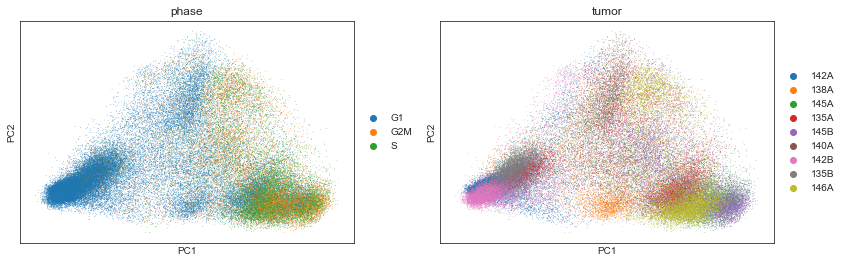

In [15]:
# sc.pp.scale(adata)
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','tumor'])

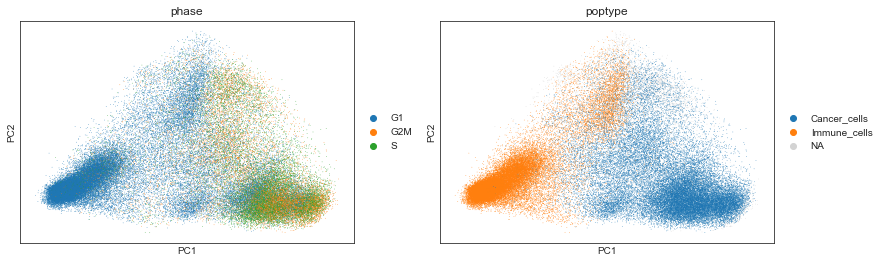

In [16]:
sc.pl.pca_scatter(adata, color=['phase','poptype'])

Interestingly, it seems that virtually all immune cells are "G1," while cancer cells are mixed. Therefore, regressing out cell cycle might get rid of some differences between the two populations, so I will leave the data as is.

In [17]:
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])


# Dimensionality Reduction and RNA Velocity

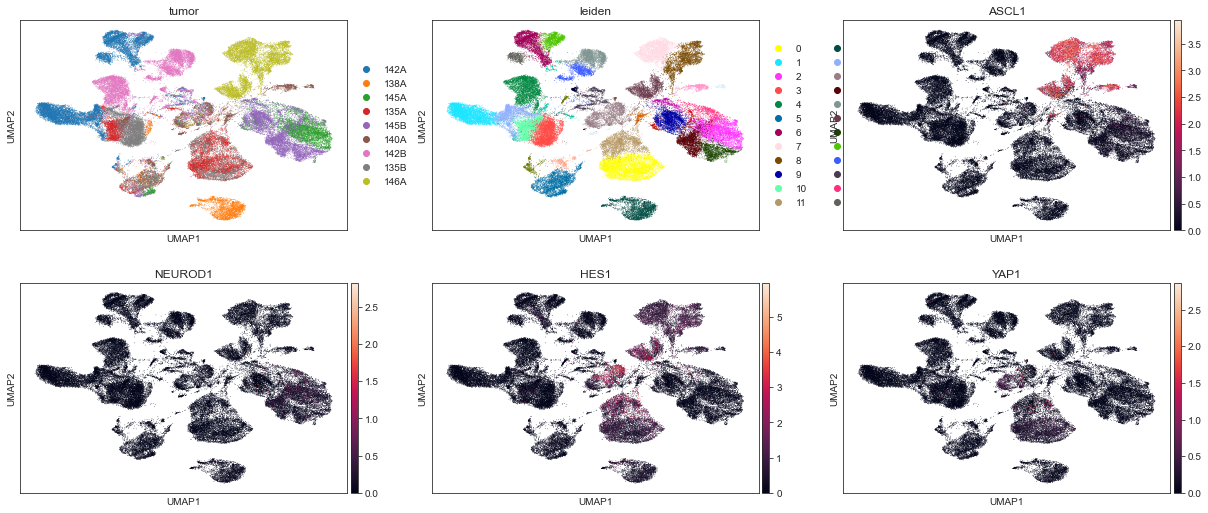

In [18]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 1)
sc.pl.umap(adata, color = ['tumor','leiden','ASCL1','NEUROD1','HES1','YAP1'], ncols = 3)


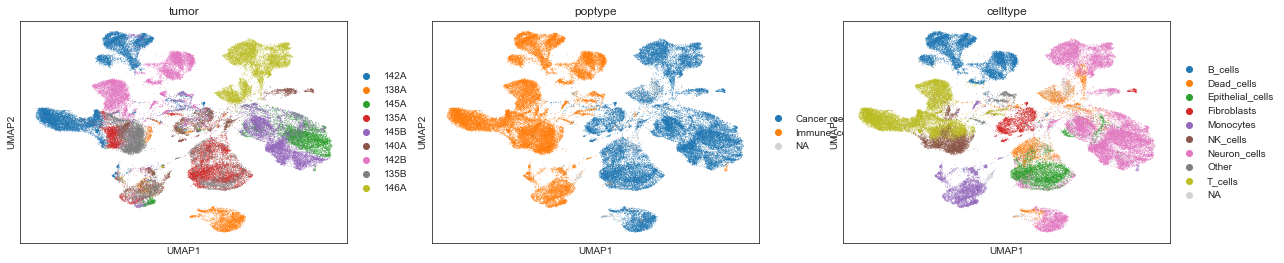

In [19]:
sc.pl.umap(adata, color = ['tumor','poptype','celltype'], ncols = 3)


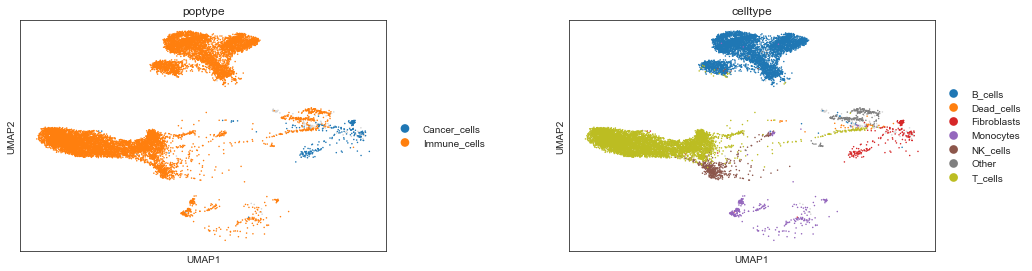

In [20]:
sc.pl.scatter(adata[adata.obs.tumor=="142A"], color = ['poptype','celltype'], basis = 'umap')


In [21]:
adata.write_h5ad(outdir+'/adata01.h5ad')

In [22]:
set(ids.type)

{'Cancer_cells.Dead_cells',
 'Cancer_cells.Epithelial_cells',
 'Cancer_cells.Fibroblasts',
 'Cancer_cells.Neuron_cells',
 'Immune_cells.B_cells',
 'Immune_cells.Monocytes',
 'Immune_cells.NK_cells',
 'Immune_cells.Other',
 'Immune_cells.T_cells'}

In [23]:
pd.crosstab(adata.obs.poptype, adata.obs.tumor, normalize="columns")

tumor             142A      138A      145A      135A      145B      140A  \
poptype                                                                    
Cancer_cells  0.021838  0.799128  0.877436  0.666625  0.880597  0.503235   
Immune_cells  0.978162  0.200872  0.122564  0.333375  0.119403  0.496765   

tumor             142B      135B      146A  
poptype                                     
Cancer_cells  0.034339  0.332797  0.989224  
Immune_cells  0.965661  0.667203  0.010776

**Conclusions**

All tumors have some cancer and immune cells, although the proportions vary greatly between the tumors. For example, 142A is almost entirely immune cells, while 146A is almost entirely cancer cells. For the most part it seems tumors before and after treatment have similar proportions, *except* 135, which originally is two thirds cancer cells and after treatment is two thirds immune cells. This may be a very interesting case for evaluating changing immune populations. 

In [24]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.tumor, normalize="columns").style.background_gradient('viridis')

When we look at the subpopulations of immune cells in each tumor, we notice a few things. 
1. 142: B cells proportion increased (\~6%); T cells decreased (~8%). Otherwise very similar
2. 145: Very different before and after. B cells increased (\~11%), monocytes decreased (~40%), NK increased, and T cells increased.
3. 135: Monocytes decreased, NK increased (\~18%), T cells decreased (~14%).


In [25]:
before = []
for i,r in adata.obs.iterrows():
    if (i[-1]) == 'A': before.append('Before')
    else: before.append('After')
    

In [26]:
adata.obs["before"] = before

In [27]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.before, normalize="columns").style.background_gradient('viridis')

<AxesSubplot:xlabel='celltype'>

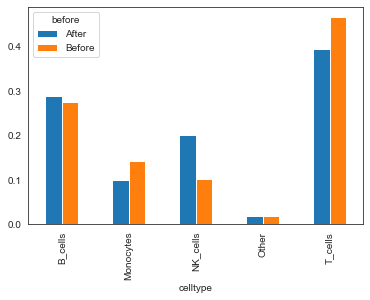

In [28]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.before, normalize = 'columns').plot(kind = 'bar')

<AxesSubplot:xlabel='tumor'>

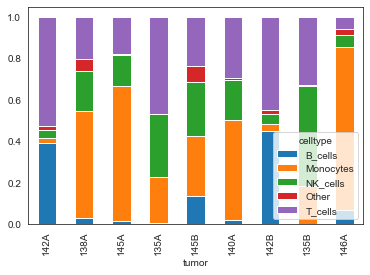

In [29]:
pd.crosstab(adata[adata.obs.poptype == 'Immune_cells'].obs.tumor, 
            adata[adata.obs.poptype == 'Immune_cells'].obs.celltype, normalize='index').plot(kind = 'bar', stacked = True)

Overall, there is a slight increase in B and NK cells after treatment, and a slight decrease in monocytes and T cells.

In [30]:
adata.write_h5ad(outdir+'/adata01.h5ad')

... storing 'before' as categorical


In [31]:
# adata = sc.read_h5ad(outdir+'/adata01.h5ad')

## Just cancer cells for plasticity analysis

In [47]:
tumor = adata[adata.obs['poptype'] == 'Cancer_cells']

In [48]:
tumor = tumor[tumor.obs['celltype'] != 'Dead_cells']

In [49]:
tumor

View of AnnData object with n_obs × n_vars = 27882 × 29568
    obs: 'tumor', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'index', 'brcd', 'poptype', 'celltype', 'S_score', 'G2M_score', 'phase', 'leiden', 'before'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'pca', 'phase_colors', 'tumor_colors', 'poptype_colors', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## RNA velocity calculation and plasticity quantification.
CDX models from the same patient before and after treatment should be combined so they are comparable (i.e. in the same "space"). However, RNA velocity should be calculated independently for each sample.

In [57]:
scv.pp.moments(tumor, n_neighbors=30, n_pcs=30)

scv.tl.velocity(tumor, vkey='deterministic_velocity', mode='deterministic', groupby = 'tumor')
scv.tl.velocity_graph(tumor, vkey='deterministic_velocity')

# scv.tl.velocity(tumor, vkey='stochastic_velocity', mode='stochastic', groupby = 'tumor')
# scv.tl.velocity_graph(tumor, vkey='stochastic_velocity')

In [56]:
# scv.tl.recover_dynamics(tumor)



In [58]:
# scv.tl.velocity(tumor, mode='dynamical', vkey='dynamical_velocity', groupby = 'tumor')
# scv.tl.velocity_graph(tumor, vkey='dynamical_velocity', variance_stabilization=True)

In [55]:
tumor.write_h5ad(outdir+'/tumor01.h5ad')

In [3]:
tumor = sc.read_h5ad(outdir+'/tumor01.h5ad')

computing velocity embedding
    finished (0:00:22) --> added
    'deterministic_velocity_umap', embedded velocity vectors (adata.obsm)


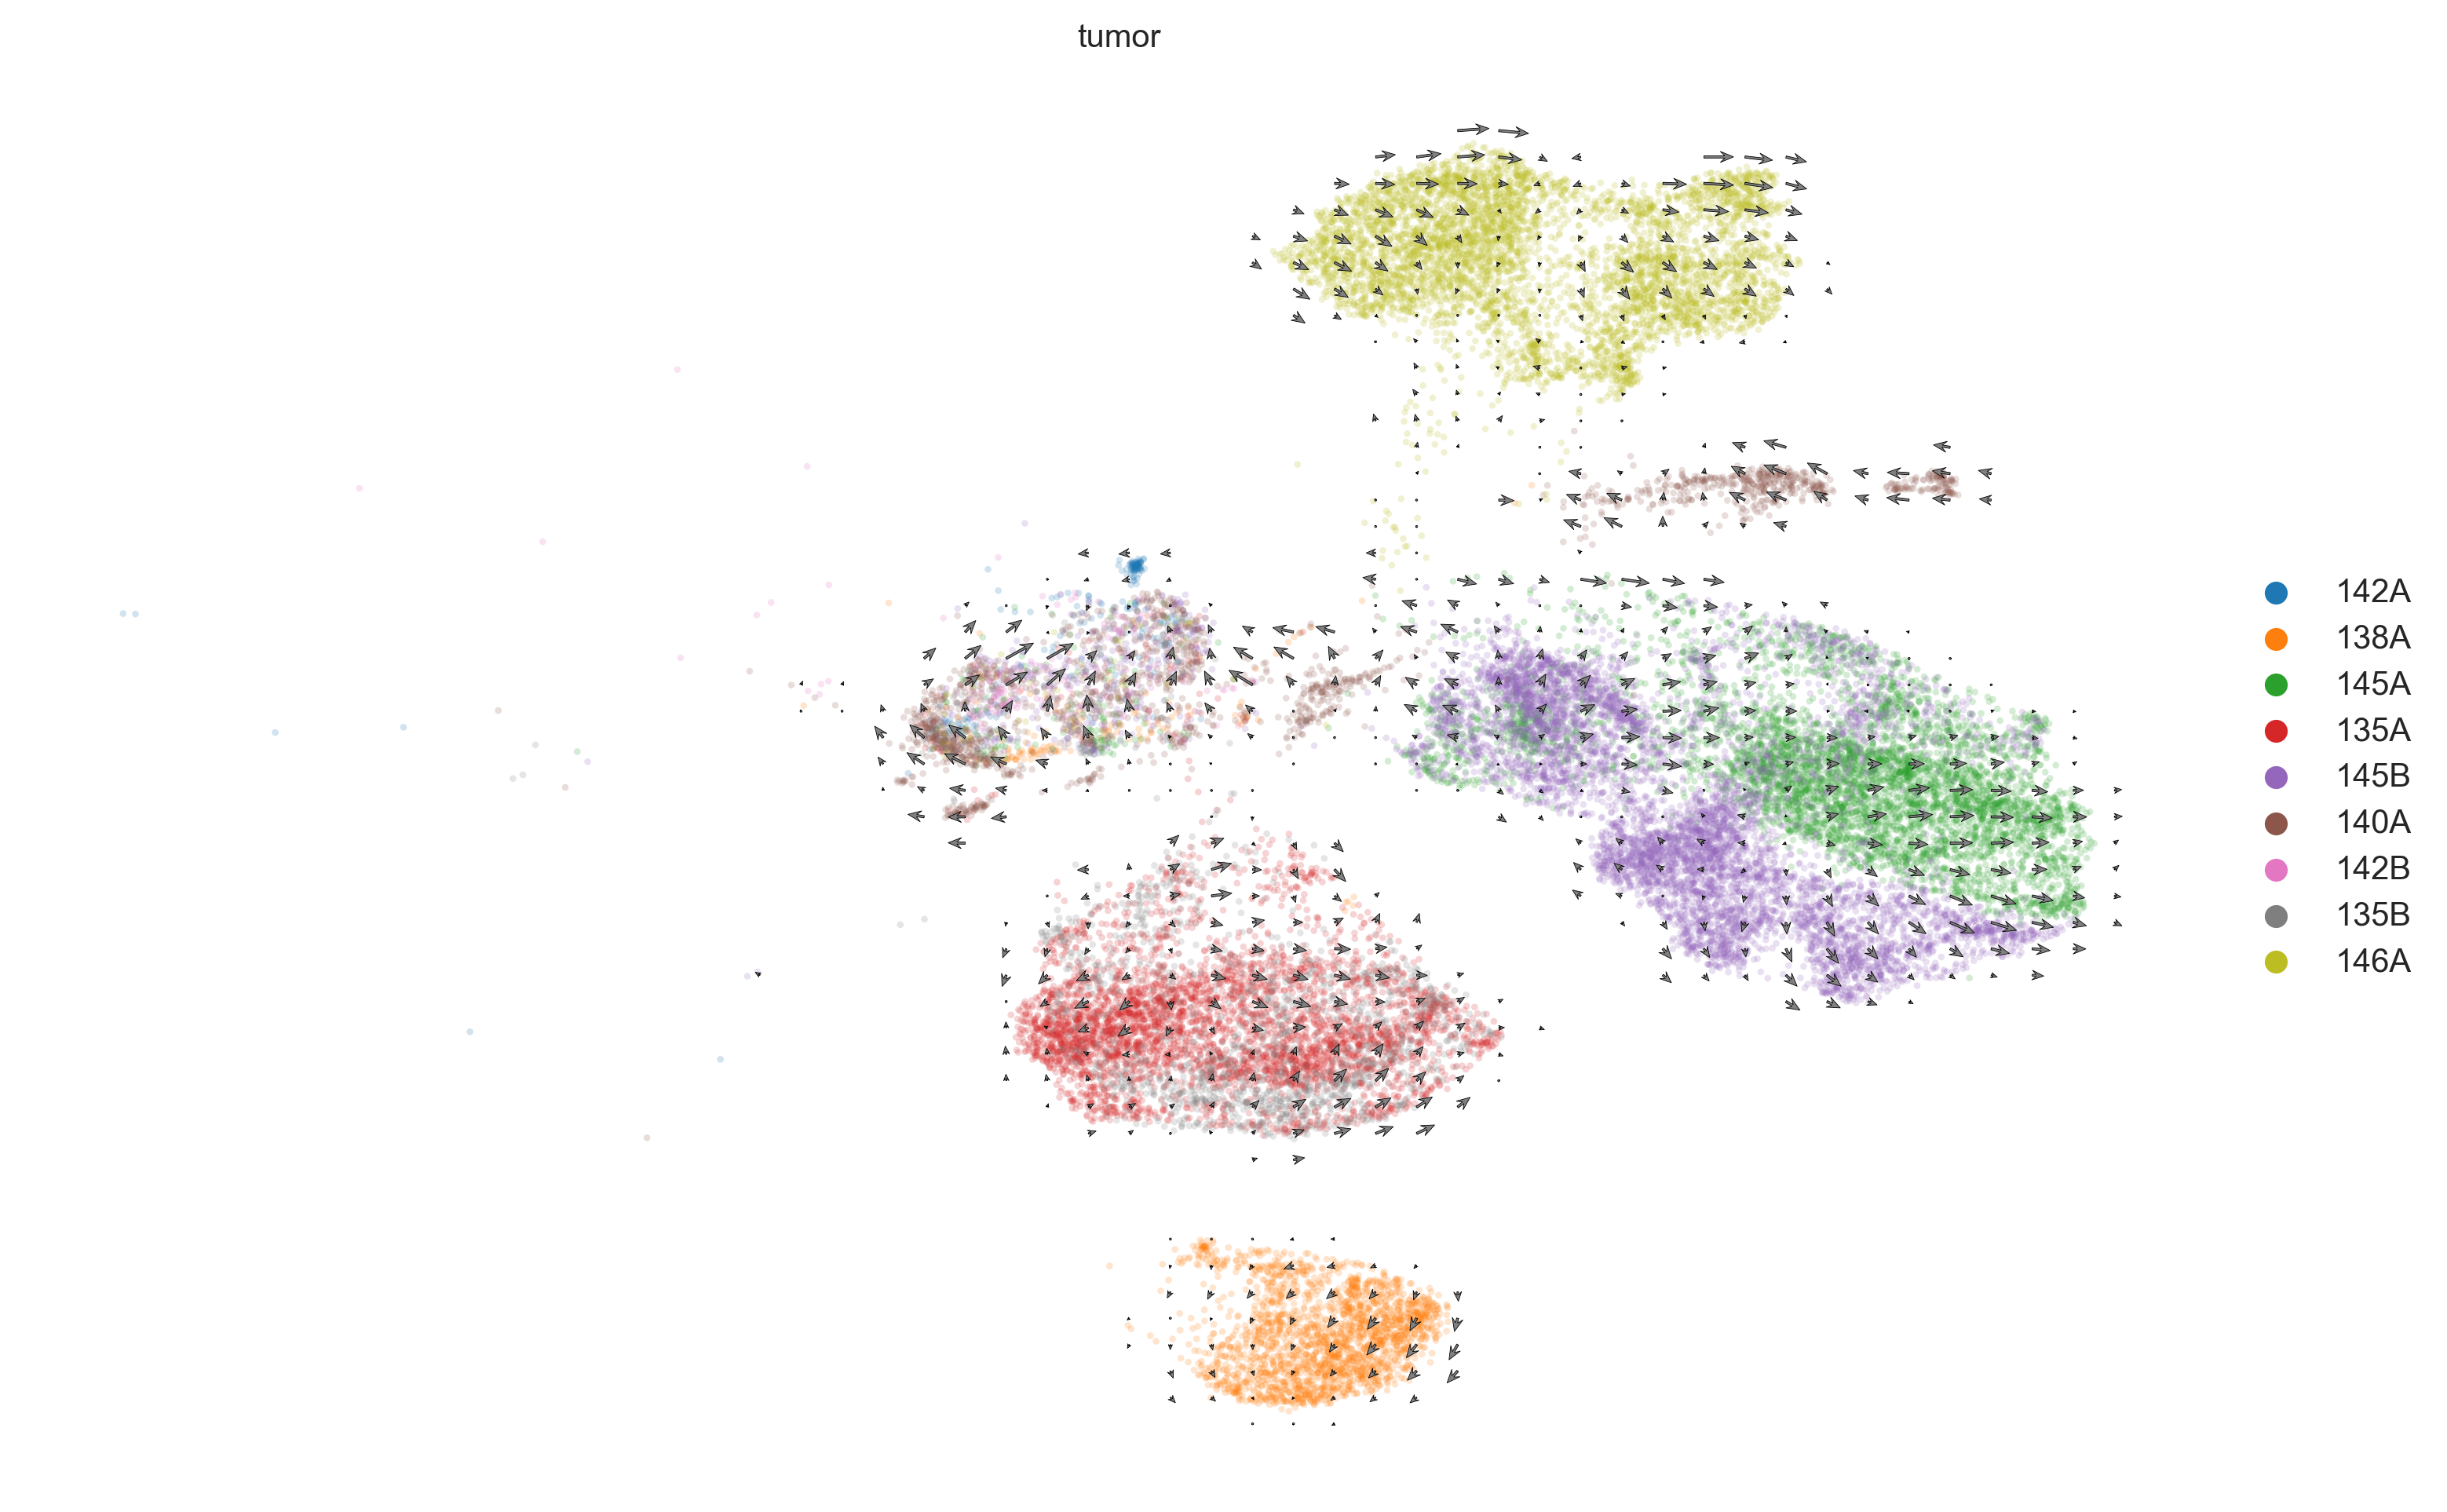

In [4]:
scv.pl.velocity_embedding_grid(tumor, color = 'tumor', figsize = (12,8), legend_loc = 'on right', dpi = 300, vkey='deterministic_velocity')

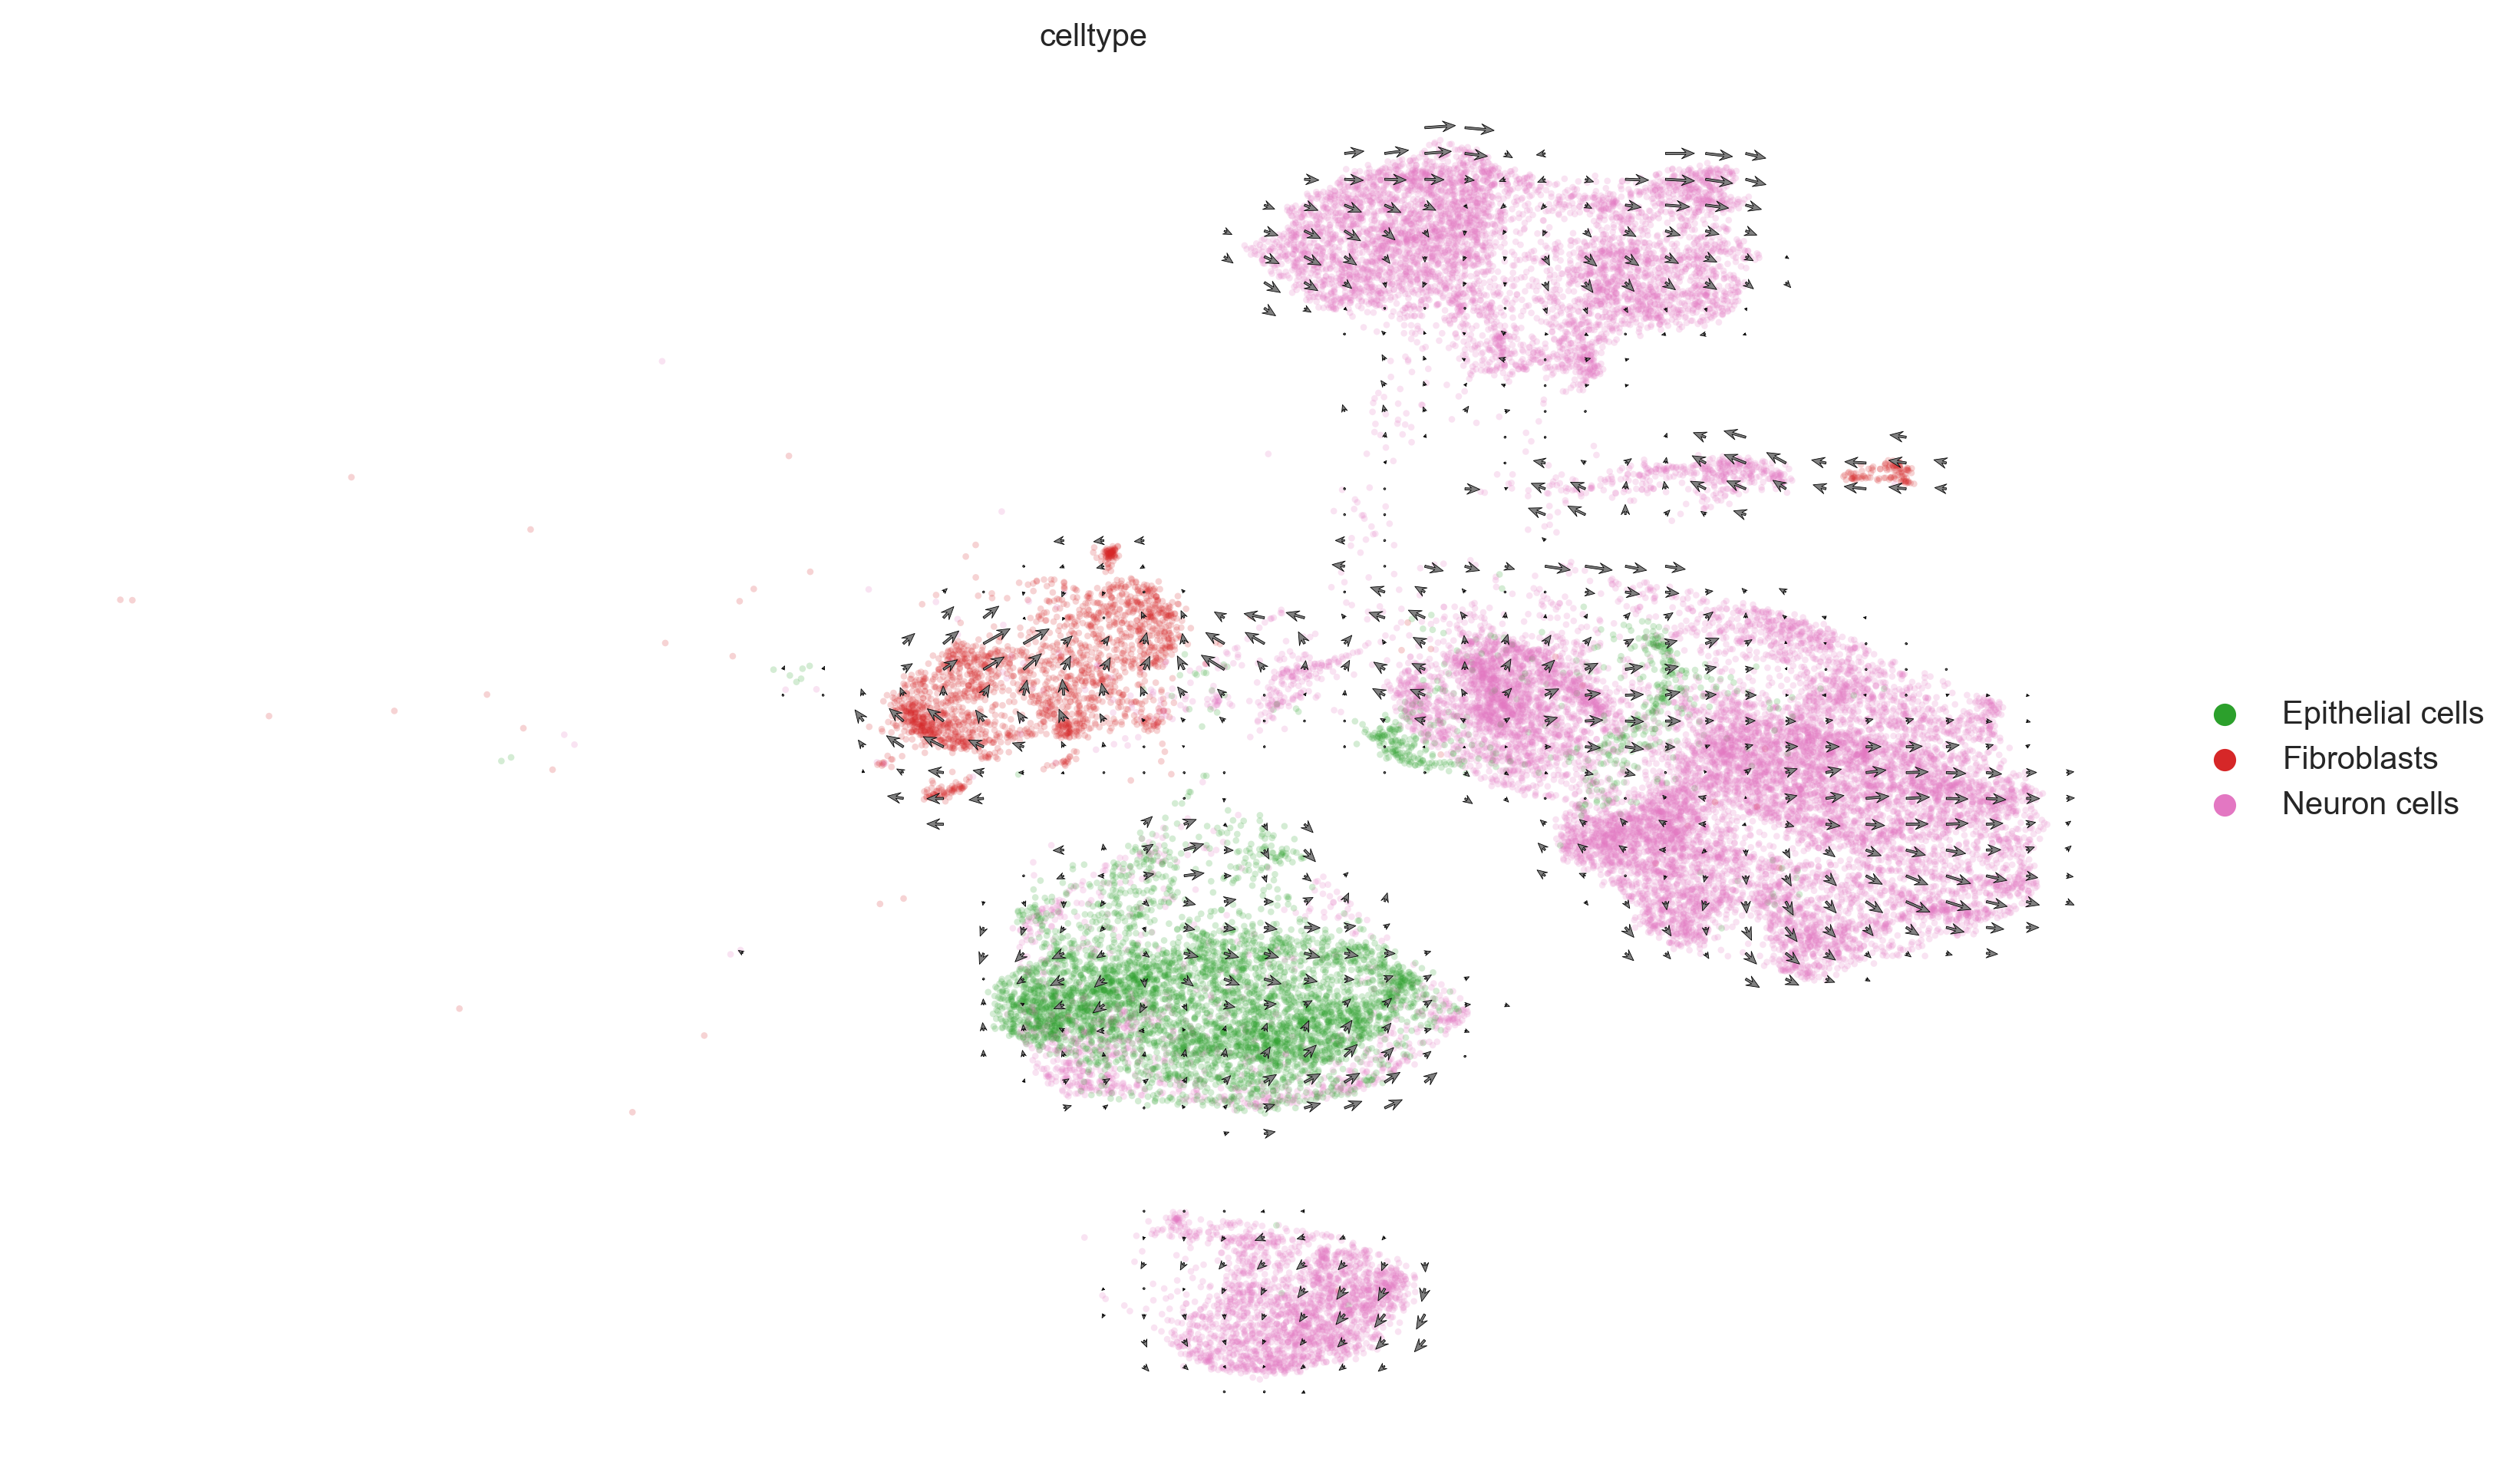

In [62]:
scv.pl.velocity_embedding_grid(tumor, color = 'celltype', figsize = (12,8), legend_loc = 'on right', dpi = 300,  vkey='deterministic_velocity')

computing terminal states
    identified 5 regions of root cells and 3 regions of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


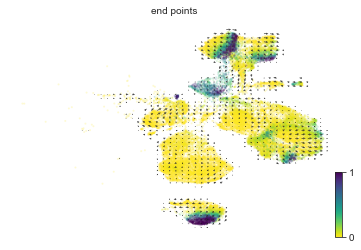

In [44]:
scv.tl.terminal_states(tumor)
scv.pl.velocity_embedding_grid(tumor, color = 'end_points')

In [65]:
tumor.obs.groupby('tumor').describe()

n_genes                                                            \
        count         mean          std    min     25%     50%      75%   
tumor                                                                     
142A    245.0  1206.722449  1355.552466  200.0   315.0   394.0  2013.00   
138A   2279.0  2919.822729  1392.170758  208.0  1954.0  2945.0  3875.00   
145A   5374.0  2619.376628  1595.726651  208.0  1379.0  2394.5  3699.25   
135A   4338.0  3924.231904  1461.404710  231.0  3115.5  4144.0  4961.00   
145B   6974.0  2529.776599  1830.123059  202.0   620.0  2488.5  3874.00   
140A   1716.0  2558.864802  1923.752198  203.0   569.0  2434.5  4146.75   
142B    158.0  1687.411392  1385.202127  210.0   446.5  1181.5  2662.50   
135B   1555.0  3623.157556  1861.453058  213.0  2125.5  3894.0  5136.50   
146A   5243.0  3385.777608  1176.756973  255.0  2519.5  3189.0  4176.50   

              initial_size_spliced                ... end_points         ctrp  \
          max                count          mean  ...        75%  max   count   
tumor                                             ...                           
142A   6325.0                245.0   3998.591837  ...   0.212473  1.0   245.0   
138A   6326.0               2279.0  10875.586222  ...   0.153337  1.0  2279.0   
145A   6795.0               5374.0   6882.382583  ...   0.050494  1.0  5374.0   
135A   6960.0               4338.0  13914.876671  ...   0.069641  1.0  4338.0   
145B   6914.0               6974.0   7052.871379  ...   0.078899  1.0  6974.0   
140A   6797.0               1716.0   9205.572844  ...   0.009315  1.0  1716.0   
142B   6665.0                158.0   6410.164557  ...   0.000000  0.0   158.0   
135B   6943.0               1555.0  14726.646945  ...   0.000000  0.0  1555.0   
146A   6858.0               5243.0   9042.595270  ...   0.000000  0.0  5243.0   

                                                                             
           mean       std       min       25%       50%       75%       max  
tumor                                                                        
142A   0.734008  1.025878 -0.025646  0.004241  0.024810  2.149876  2.533333  
138A   2.243333  0.715177  0.000000  1.845957  2.194649  2.597121  4.144770  
145A   2.803058  0.671147  0.000000  2.516789  2.876434  3.221044  4.122717  
135A   1.955913  0.749452  0.000000  1.786789  2.290210  2.433401  2.996471  
145B   2.707826  0.844666  0.000000  2.215180  2.682108  3.515205  4.115014  
140A   2.308643  0.592185  0.000000  2.119894  2.494317  2.706105  3.127802  
142B   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
135B   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
146A   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[9 rows x 80 columns]

Tumor 145B is causing a problem because there aren't even cells, so the transition matrix is singular. I am going to remove it for the plasticity analysis.

In [5]:
b142 = tumor[(tumor.obs.tumor == '142B')]
b142

View of AnnData object with n_obs × n_vars = 158 × 29568
    obs: 'tumor', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'index', 'brcd', 'poptype', 'celltype', 'S_score', 'G2M_score', 'phase', 'leiden', 'before', 'deterministic_velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'deterministic_velocity_gamma_142A', 'deterministic_velocity_qreg_ratio_142A', 'deterministic_velocity_r2_142A', 'deterministic_velocity_genes_142A', 'deterministic_velocity_gamma_138A', 'deterministic_velocity_qreg_ratio_138A', 'deterministic_velocity_r2_138A', 'deterministic_velocity_genes_138A', 'deterministic_velocity_gamma_145A', 'deterministic_velocity_qreg_ratio_145A', 'deterministic_velocity_r2_145A', 'deterministic_velocity_genes_145A', 'deterministic_velocity_gamma_135A', 'deterministic_velocity_qreg_ratio_135A', 'deterministic_velocity_r2_135A', 'deterministic_velocity_genes_135A', 'deterministic_veloci

In [6]:
A146 = tumor[(tumor.obs.tumor == '146A')]
A146

View of AnnData object with n_obs × n_vars = 5243 × 29568
    obs: 'tumor', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'index', 'brcd', 'poptype', 'celltype', 'S_score', 'G2M_score', 'phase', 'leiden', 'before', 'deterministic_velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'deterministic_velocity_gamma_142A', 'deterministic_velocity_qreg_ratio_142A', 'deterministic_velocity_r2_142A', 'deterministic_velocity_genes_142A', 'deterministic_velocity_gamma_138A', 'deterministic_velocity_qreg_ratio_138A', 'deterministic_velocity_r2_138A', 'deterministic_velocity_genes_138A', 'deterministic_velocity_gamma_145A', 'deterministic_velocity_qreg_ratio_145A', 'deterministic_velocity_r2_145A', 'deterministic_velocity_genes_145A', 'deterministic_velocity_gamma_135A', 'deterministic_velocity_qreg_ratio_135A', 'deterministic_velocity_r2_135A', 'deterministic_velocity_genes_135A', 'deterministic_veloc

In [12]:
import warnings

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, SparseEfficiencyWarning
from scipy.spatial.distance import pdist, squareform

from scvelo.preprocessing.neighbors import get_connectivities, get_neighs
from scvelo.utils import normalize

In [9]:

def transition_matrix(
    adata,
    vkey="velocity",
    basis=None,
    backward=False,
    self_transitions=True,
    scale=10,
    perc=None,
    threshold=None,
    use_negative_cosines=False,
    weight_diffusion=0,
    scale_diffusion=1,
    weight_indirect_neighbors=None,
    n_neighbors=None,
    vgraph=None,
    basis_constraint=None,
):
    """Computes cell-to-cell transition probabilities
    .. math::
        \\tilde \\pi_{ij} = \\frac1{z_i} \\exp( \\pi_{ij} / \\sigma),
    from the velocity graph :math:`\\pi_{ij}`, with row-normalization :math:`z_i` and
    kernel width :math:`\\sigma` (scale parameter :math:`\\lambda = \\sigma^{-1}`).
    Alternatively, use :func:`cellrank.tl.transition_matrix` to account for uncertainty
    in the velocity estimates.
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    vkey: `str` (default: `'velocity'`)
        Name of velocity estimates to be used.
    basis: `str` or `None` (default: `None`)
        Restrict transition to embedding if specified
    backward: `bool` (default: `False`)
        Whether to use the transition matrix to
        push forward (`False`) or to pull backward (`True`)
    self_transitions: `bool` (default: `True`)
        Allow transitions from one node to itself.
    scale: `float` (default: 10)
        Scale parameter of gaussian kernel.
    perc: `float` between `0` and `100` or `None` (default: `None`)
        Determines threshold of transitions to include.
    use_negative_cosines: `bool` (default: `False`)
        If True, negatively similar transitions are taken into account.
    weight_diffusion: `float` (default: 0)
        Relative weight to be given to diffusion kernel (Brownian motion)
    scale_diffusion: `float` (default: 1)
        Scale of diffusion kernel.
    weight_indirect_neighbors: `float` between `0` and `1` or `None` (default: `None`)
        Weight to be assigned to indirect neighbors (i.e. neighbors of higher degrees).
    n_neighbors:`int` (default: None)
        Number of nearest neighbors to consider around each cell.
    vgraph: csr matrix or `None` (default: `None`)
        Velocity graph representation to use instead of adata.uns[f'{vkey}_graph'].
    Returns
    -------
    Returns sparse matrix with transition probabilities.
    """

    if f"{vkey}_graph" not in adata.uns:
        raise ValueError(
            "You need to run `tl.velocity_graph` first to compute cosine correlations."
        )

    graph_neg = None
    if vgraph is not None:
        graph = vgraph.copy()
    else:
        if hasattr(adata, "obsp") and f"{vkey}_graph" in adata.obsp.keys():
            graph = csr_matrix(adata.obsp[f"{vkey}_graph"]).copy()
            if f"{vkey}_graph_neg" in adata.obsp.keys():
                graph_neg = adata.obsp[f"{vkey}_graph_neg"]
        else:
            graph = csr_matrix(adata.uns[f"{vkey}_graph"]).copy()
            if f"{vkey}_graph_neg" in adata.uns.keys():
                graph_neg = adata.uns[f"{vkey}_graph_neg"]

    if basis_constraint is not None and f"X_{basis_constraint}" in adata.obsm.keys():
        from sklearn.neighbors import NearestNeighbors

        neighs = NearestNeighbors(n_neighbors=100)
        neighs.fit(adata.obsm[f"X_{basis_constraint}"])
        basis_graph = neighs.kneighbors_graph(mode="connectivity") > 0
        graph = graph.multiply(basis_graph)

    if self_transitions:
        confidence = graph.max(1).A.flatten()
        ub = np.percentile(confidence, 98)
        self_prob = np.clip(ub - confidence, 0, 1)
        graph.setdiag(self_prob)

    T = np.expm1(graph * scale)  # equivalent to np.exp(graph.A * scale) - 1
    if graph_neg is not None:
        graph_neg = adata.uns[f"{vkey}_graph_neg"]
        if use_negative_cosines:
            T -= np.expm1(-graph_neg * scale)
        else:
            T += np.expm1(graph_neg * scale)
            T.data += 1

    # weight direct and indirect (recursed) neighbors
    if weight_indirect_neighbors is not None and weight_indirect_neighbors < 1:
        direct_neighbors = get_neighs(adata, "distances") > 0
        direct_neighbors.setdiag(1)
        w = weight_indirect_neighbors
        T = w * T + (1 - w) * direct_neighbors.multiply(T)

    if n_neighbors is not None:
        T = T.multiply(
            get_connectivities(
                adata, mode="distances", n_neighbors=n_neighbors, recurse_neighbors=True
            )
        )

    if perc is not None or threshold is not None:
        if threshold is None:
            threshold = np.percentile(T.data, perc)
        T.data[T.data < threshold] = 0
        T.eliminate_zeros()

    if backward:
        T = T.T
    T = normalize(T)

    if f"X_{basis}" in adata.obsm.keys():
        dists_emb = (T > 0).multiply(squareform(pdist(adata.obsm[f"X_{basis}"])))
        scale_diffusion *= dists_emb.data.mean()

        diffusion_kernel = dists_emb.copy()
        diffusion_kernel.data = np.exp(
            -0.5 * dists_emb.data ** 2 / scale_diffusion ** 2
        )
        T = T.multiply(diffusion_kernel)  # combine velocity kernel & diffusion kernel

        if 0 < weight_diffusion < 1:  # add diffusion kernel (Brownian motion - like)
            diffusion_kernel.data = np.exp(
                -0.5 * dists_emb.data ** 2 / (scale_diffusion / 2) ** 2
            )
            T = (1 - weight_diffusion) * T + weight_diffusion * diffusion_kernel

        T = normalize(T)

    return T

In [14]:
A146_tm = transition_matrix(A146, vkey = 'deterministic_velocity')

In [15]:
b142_tm = transition_matrix(b142, vkey = 'deterministic_velocity')

In [16]:
import scipy 
scipy.sparse.save_npz('../data/patient-biopsies/transition_matrix_B142.npz', b142_tm)
scipy.sparse.save_npz('../data/patient-biopsies/transition_matrix_A146.npz', A146_tm)

In [22]:
connectivities = get_connectivities(A146, 'distances')

Q, ends = mb.ps.extract_Q(A146_tm.todense(), connectivities = connectivities, eigen=True,eps = 1e-2, eps_eig = 1e-3)


Eigenvalues:  [1.0000017  1.0000011  0.99995327 0.9998521 ]
    identified 4 end points


In [26]:
np.savetxt('../data/patient-biopsies/Q_A146.csv', Q)

In [27]:
connectivities = get_connectivities(b142, 'distances')

Q, ends = mb.ps.extract_Q(b142_tm.todense(), connectivities = connectivities, eigen=True,eps = 1e-2, eps_eig = 1e-3)
np.savetxt('../data/patient-biopsies/Q_b142.csv', Q)

Eigenvalues:  [1.0000042 1.       ]
    identified 2 end points


In [68]:
adata = tumor.copy()
adata = adata[(adata.obs.tumor != '142B') & (adata.obs.tumor != '146A')] 
mb.ps.ctrp_simplified(adata, distance_basis='X_pca', groupby = 'tumor', vkey = 'deterministic_velocity')


(142A)
Eigenvalues:  [1.0000002  0.9998975  0.99981445 0.9994235 ]
    identified 4 end points


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.


[[1.36999838e-15 5.75005269e-16 4.85056837e-16 ... 0.00000000e+00
  2.00059727e-16 3.14006822e-15]
 [1.56940314e-01 1.33409522e-01 2.82380956e-01 ... 0.00000000e+00
  2.06345696e-01 2.16307814e-01]
 [1.36999970e-15 5.75005825e-16 4.85057306e-16 ... 0.00000000e+00
  2.00059921e-16 3.14007126e-15]
 ...
 [1.83657648e-01 6.72340411e-02 2.88642847e-01 ... 0.00000000e+00
  2.24064860e-01 2.25311541e-01]
 [1.59650043e-01 6.81319556e-02 3.05371901e-01 ... 0.00000000e+00
  2.37513766e-01 2.26382225e-01]
 [1.65912704e-01 1.19726330e-01 2.77238810e-01 ... 0.00000000e+00
  2.03907779e-01 2.23895028e-01]]
(138A)
Eigenvalues:  [1.0000038 0.9999544]
    identified 2 end points


Trying to set attribute `.obs` of view, copying.


[[1.78629922e-02 1.51961191e-02 3.77629591e-04 ... 6.64839053e-03
  2.71047783e-02 1.83693386e-02]
 [1.42698799e-02 1.18400301e-02 8.88573416e-05 ... 7.09363318e-03
  2.75404360e-02 1.58067315e-02]
 [1.54824060e-02 1.17339229e-02 8.52043157e-05 ... 5.81668655e-03
  2.43316675e-02 1.71325993e-02]
 ...
 [1.60709741e-02 1.18038007e-02 9.87711214e-05 ... 6.15206462e-03
  2.47256663e-02 1.70524715e-02]
 [1.78387741e-02 1.23143321e-02 6.71291474e-05 ... 5.12680120e-03
  2.33078658e-02 1.84224600e-02]
 [1.58426317e-02 1.15992491e-02 1.42066665e-04 ... 6.15517896e-03
  2.45767377e-02 1.67839303e-02]]
(145A)
Eigenvalues:  [0.9999996  0.99997514]
    identified 2 end points


Trying to set attribute `.obs` of view, copying.


[[0.01507361 0.01306097 0.01590586 ... 0.00793613 0.00177198 0.00194177]
 [0.01516885 0.01140934 0.00924251 ... 0.01591249 0.00154649 0.00396475]
 [0.01260352 0.01247642 0.00775822 ... 0.02234941 0.00223014 0.00132508]
 ...
 [0.01301193 0.00652954 0.01271579 ... 0.00493073 0.00429796 0.01138518]
 [0.01498831 0.01134709 0.0089486  ... 0.01635644 0.00155605 0.00407459]
 [0.01569218 0.02593699 0.01276291 ... 0.01204666 0.001996   0.00090856]]
(135A)
Eigenvalues:  [1.0000033  1.0000024  0.99999857 0.99983114 0.9993793 ]
    identified 5 end points


Trying to set attribute `.obs` of view, copying.


[[2.19205571e-05 1.37218889e-15 3.81397712e-03 ... 3.13891091e-03
  3.81595353e-02 1.52795712e-03]
 [1.29603806e-05 9.43193922e-16 3.03364669e-03 ... 2.72446632e-03
  5.27283605e-02 9.99331754e-04]
 [2.09161305e-05 6.58876269e-15 6.35079864e-03 ... 6.14214693e-03
  3.98927438e-02 1.62567724e-03]
 ...
 [2.81223848e-05 1.65159363e-15 4.87063961e-03 ... 4.05601461e-03
  3.64772077e-02 2.90627352e-03]
 [2.19195826e-05 1.37214156e-15 3.81385366e-03 ... 3.13880971e-03
  3.81599218e-02 1.52792732e-03]
 [1.06212485e-05 6.62243116e-16 3.31504108e-03 ... 3.52197870e-03
  5.39421434e-02 1.11133352e-03]]
(145B)
Eigenvalues:  [1.0000142  0.99998796]
    identified 2 end points


Trying to set attribute `.obs` of view, copying.


[[0.02519002 0.01675285 0.00037754 ... 0.0010521  0.00057634 0.01014951]
 [0.00251698 0.00132193 0.00050483 ... 0.00249717 0.00021123 0.00098903]
 [0.0201727  0.01332051 0.00041806 ... 0.00163698 0.00040018 0.01426887]
 ...
 [0.00254482 0.00147517 0.00074191 ... 0.00255652 0.00024298 0.00122617]
 [0.00153001 0.0008357  0.00075541 ... 0.00260306 0.00022779 0.00054195]
 [0.00251094 0.00113742 0.00065973 ... 0.00249004 0.00024247 0.0008879 ]]
(140A)
Eigenvalues:  [1.0000023  0.99999857 0.99999523 0.99972355]
    identified 4 end points


Trying to set attribute `.obs` of view, copying.


[[0.03369245 0.02860076 0.01127138 ... 0.00900477 0.03160332 0.0168412 ]
 [0.00647704 0.02815605 0.00556982 ... 0.00280261 0.02673943 0.00956708]
 [0.00273891 0.00557344 0.00400112 ... 0.00088058 0.00811271 0.00270754]
 ...
 [0.0318344  0.02071323 0.03327285 ... 0.01402011 0.01917709 0.04499318]
 [0.01018067 0.02649363 0.0153686  ... 0.00401296 0.03060476 0.01505887]
 [0.03783935 0.02729656 0.01711226 ... 0.00893807 0.02959063 0.01583027]]
(135B)
Eigenvalues:  [1.0000024  1.0000002  1.         0.999999   0.99999416 0.99992067
 0.9999073  0.99985534 0.9998379  0.999812   0.9996358  0.99927145]
    identified 12 end points


Trying to set attribute `.obs` of view, copying.


[[6.88715226e-08 3.04140236e-10 2.94742095e-02 ... 1.42810150e-02
  7.36705839e-02 1.91889182e-01]
 [1.77650950e-08 1.51469756e-10 6.37027543e-03 ... 5.18226507e-03
  1.03328164e-01 1.21042288e-01]
 [1.46095457e-08 2.76662726e-10 1.08842920e-01 ... 7.29161820e-02
  1.65078172e-02 2.82635826e-01]
 ...
 [1.54501117e-08 1.39663833e-10 2.78635694e-03 ... 2.19207720e-03
  1.12989751e-01 5.84437825e-02]
 [6.28655627e-09 1.06160823e-10 3.04966311e-01 ... 8.64997730e-02
  1.27462788e-02 2.03382484e-01]
 [1.26993892e-08 1.66407731e-10 1.05423325e-01 ... 4.10479844e-02
  2.65974543e-02 2.71231319e-01]]


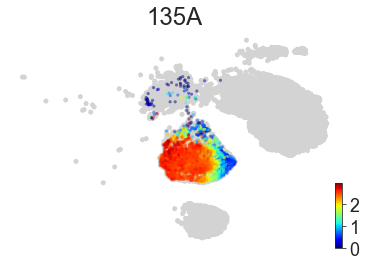

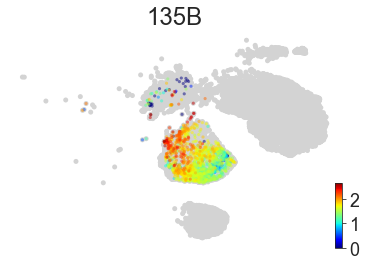

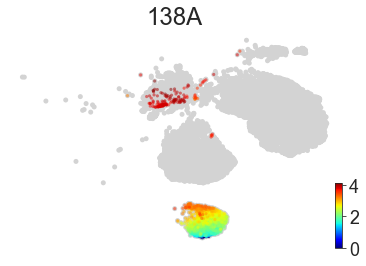

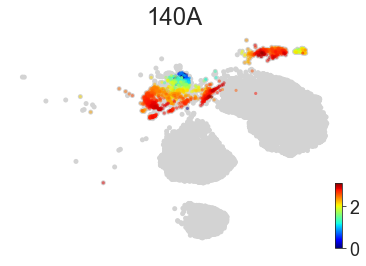

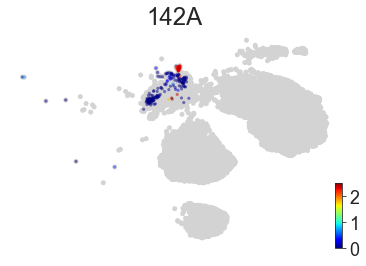

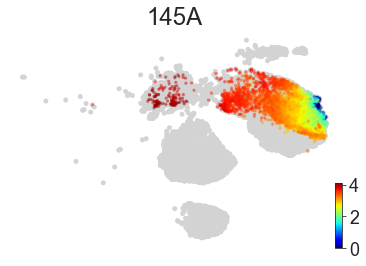

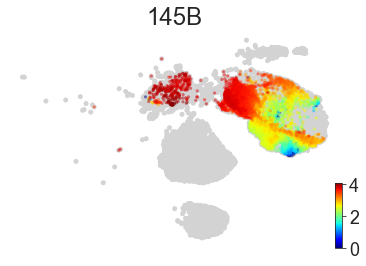

In [69]:
mb.pl.ctrp_groups(adata, groups = 'tumor', basis = 'umap')


As a way to group cells, can I try using metacell to annotate the data, and then a PAGA graph on these labels?